# Digit Recognition Using Machine Learning

## Objective:
Develop a Jupyter notebook that uses a machine learning model to identify and classify
handwritten digits.

## Tasks:

1. Import Libraries
2. Data Loading & PreProcessing
3. Model Selection
4. Training
5. Evaluation
6. Inference

## 1. Import Libraries

In [103]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

import random
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.1+cu117
torchvision version: 0.14.1+cu117


## 2. Data Loading and Pre-Processing

For this task, it is necessary to download the MNIST dataset locally and create the dataloaders to feed the model.

1. Download & Load Data
2. Visualize samples
3. Create DataLoader
4. Verify DataLoders
5. Create a function (replicate the task)


### 2.1 Download & Load Data

Download Data Locally and Load it to `train_data` and `test_data`. Check length and class names

In [3]:
data_root = 'data'

In [45]:
train_data = datasets.MNIST(
    root=data_root, 
    train=True,
    download=True, 
    transform=transforms.ToTensor(),
)

test_data = datasets.MNIST(
    root=data_root,
    train=False, 
    download=True,
    transform=transforms.ToTensor()
)

In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [7]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### 2.2. Visualize random samples

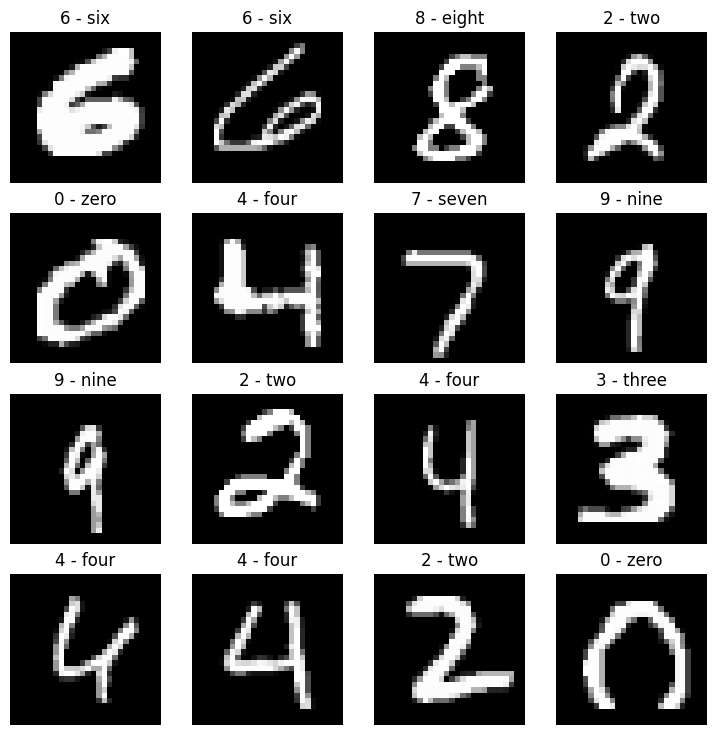

In [12]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False);

### 2.3. Create DataLoaders

In [140]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


### 2.4. Verify DataLoaders with Visualization

In [141]:
def plot_random_image_batch(dataloader: torch.utils.data.DataLoader)-> None: 
    '''
    Plot a random image from a data batch
    '''
    train_features_batch, train_labels_batch = next(iter(dataloader))
    train_features_batch.shape, train_labels_batch.shape

    random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
    img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
    plt.imshow(img[0,:,:], cmap="gray")
    plt.title(class_names[label])
    plt.axis("Off");
    print(f"Image size: {img.shape}")
    print(f"Label: {label}, label size: {label.shape}")

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


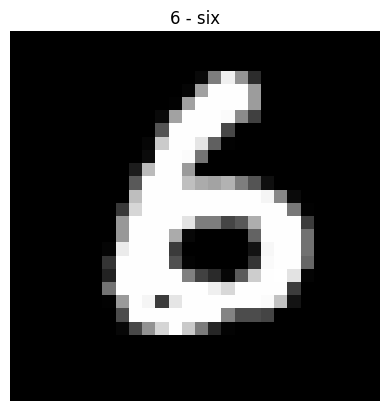

In [142]:
plot_random_image_batch (train_dataloader)

### 2.5. Create a function to create dataloaders

In [48]:
def get_dataloaders(transforms_data: torchvision.transforms = transforms.ToTensor(),
                    BATCH_SIZE: int = 32)-> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    '''
    Creates a train and test DataLoaders from MNIST dataset
    '''
    train_data = datasets.MNIST(
        root=data_root, 
        train=True,
        download=True, 
        transform=transforms_data,
    )

    test_data = datasets.MNIST(
        root=data_root,
        train=False, 
        download=True,
        transform=transforms_data,
    )
    
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataloader, test_dataloader

In [143]:
train_dataloader, test_dataloader = get_dataloaders()

In [144]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## 3. Model Selection

For this task, a custom MLP, CNN and Pretrained Model were created. 
You can see the following information:
* Model Architecture
* Forward pass in single batch sample
* Model Summary (trainable and non-trainable parameters)

In [22]:
# Sample to valid forward pass in custom models
train_features_batch[0].shape, train_labels_batch[0].shape

(torch.Size([1, 28, 28]), torch.Size([]))

### 3.1. Custom MLP

In [18]:
class MLPModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [26]:
model_mlp = MLPModel(input_shape=784, hidden_units=128, output_shape=len(class_names))
model_mlp

MLPModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [34]:
## FORWARD PASS
model_mlp(train_features_batch[0].unsqueeze(0))

tensor([[0.0151, 0.0000, 0.0000, 0.0965, 0.0327, 0.0648, 0.0374, 0.0381, 0.0514,
         0.0084]], grad_fn=<ReluBackward0>)

In [36]:
summary(model=model_mlp,
        input_size=(1,1,28,28),
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
MLPModel (MLPModel)                      [1, 1, 28, 28]       [1, 10]              True
├─Sequential (layer_stack)               [1, 1, 28, 28]       [1, 10]              True
│    └─Flatten (0)                       [1, 1, 28, 28]       [1, 784]             --
│    └─Linear (1)                        [1, 784]             [1, 128]             True
│    └─ReLU (2)                          [1, 128]             [1, 128]             --
│    └─Linear (3)                        [1, 128]             [1, 10]              True
│    └─ReLU (4)                          [1, 10]              [1, 10]              --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

### 3.2. Custom CNN

In [25]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
                                    nn.Conv2d(in_channels=input_shape,
                                              out_channels=hidden_units,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_units,
                                              out_channels=hidden_units,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2,
                                                stride=2)
            )
        
        self.block_2 = nn.Sequential(
                                    nn.Conv2d(hidden_units,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(hidden_units,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2)
            )
        self.classifier = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
            )
        
    def forward(self, x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [32]:
model_cnn = CNNModel(input_shape=1, hidden_units=10, output_shape=len(class_names))
model_cnn

CNNModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [33]:
## FORWARD PASS
model_cnn(train_features_batch[0].unsqueeze(0))

tensor([[ 0.0776,  0.0327, -0.0298, -0.0315, -0.0087,  0.0006, -0.0091, -0.0467,
          0.0237, -0.0552]], grad_fn=<AddmmBackward0>)

In [37]:
summary(model=model_cnn,
        input_size=(1,1,28,28),
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
CNNModel (CNNModel)                      [1, 1, 28, 28]       [1, 10]              True
├─Sequential (block_1)                   [1, 1, 28, 28]       [1, 10, 14, 14]      True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 10, 28, 28]      True
│    └─ReLU (1)                          [1, 10, 28, 28]      [1, 10, 28, 28]      --
│    └─Conv2d (2)                        [1, 10, 28, 28]      [1, 10, 28, 28]      True
│    └─ReLU (3)                          [1, 10, 28, 28]      [1, 10, 28, 28]      --
│    └─MaxPool2d (4)                     [1, 10, 28, 28]      [1, 10, 14, 14]      --
├─Sequential (block_2)                   [1, 10, 14, 14]      [1, 10, 7, 7]        True
│    └─Conv2d (0)                        [1, 10, 14, 14]      [1, 10, 14, 14]      True
│    └─ReLU (1)                          [1, 10, 14, 14]      [1, 10, 14, 14]      --
│    └─Conv2d (2)                  

### 3.3. PreTrained Model

In [117]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_tf = torchvision.models.efficientnet_b0(weights=weights) 

for param in model_tf.features.parameters():
    param.requires_grad = False
    
model_tf.classifier = nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                 nn.Linear(in_features=1280, 
                                           out_features=len(class_names),
                                           bias=True))

**Different DataLoader since pretrained model needs different input shape**

In [80]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
train_dataloader_v2, test_dataloader_v2 = get_dataloaders(transforms_data = manual_transforms, BATCH_SIZE=4)

Image size: torch.Size([3, 224, 224])
Label: 7, label size: torch.Size([])


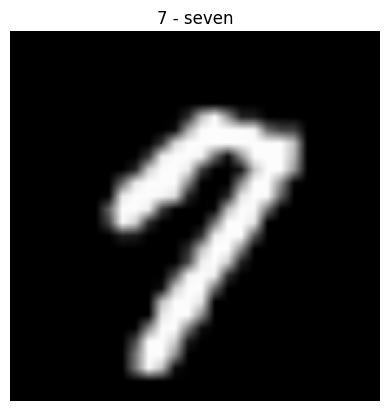

In [88]:
plot_random_image_batch (train_dataloader_v2)

In [90]:
## FORWARD PASS
model_pre_trained(next(iter(train_dataloader_v2))[0])

tensor([[-0.0784, -0.1751, -0.1521, -0.2672,  0.1985,  0.2972,  0.1490, -0.2151,
          0.0364,  0.2416],
        [-0.0224, -0.4143, -0.1443,  0.2903,  0.0465, -0.0667,  0.2194,  0.3859,
          0.0527, -0.1532],
        [ 0.2609,  0.1129, -0.4453, -0.1768,  0.2092, -0.0909, -0.0757, -0.0248,
          0.1859,  0.3083],
        [ 0.2879, -0.2971, -0.1263,  0.0989, -0.0811,  0.1213,  0.5030, -0.1060,
          0.0666, -0.1978]], grad_fn=<AddmmBackward0>)

In [91]:
summary(model=model_pre_trained,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 10]              Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    │    └─MBConv (0)                                       [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    └─Sequentia

## 4. Training

For the training task, we only used the `MLPModel` and `CNNModel`. The history of losses and performance over epochs are saved.

In [112]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    Train a PyTorch model for a single epoch.

    """

    model.train()
    train_loss, train_acc = 0, 0


    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """
    Test a PyTorch model for a single epoch.

    """
    model.eval() 
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
        
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }

    # Loop through training and testing steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [119]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_mlp.parameters(), 
                            lr=0.1)
# model_mlp = model_mlp.to(device)
torch.manual_seed(42)

train_time_start_on_gpu = timer()

results_mlp = train(model=model_mlp,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Train time on {device}: {total_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0140 | train_acc: 0.9974 | test_loss: 0.0738 | test_acc: 0.9777
Epoch: 2 | train_loss: 0.0123 | train_acc: 0.9980 | test_loss: 0.0693 | test_acc: 0.9802
Epoch: 3 | train_loss: 0.0112 | train_acc: 0.9984 | test_loss: 0.0720 | test_acc: 0.9791
Epoch: 4 | train_loss: 0.0101 | train_acc: 0.9986 | test_loss: 0.0706 | test_acc: 0.9810
Epoch: 5 | train_loss: 0.0087 | train_acc: 0.9989 | test_loss: 0.0699 | test_acc: 0.9807
Train time on cuda: 20.946 seconds


In [114]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn.parameters(), 
                            lr=0.1)
model_cnn.to(device)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

results_cnn = train(model=model_cnn,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Train time on {device}: {total_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3100 | train_acc: 0.8937 | test_loss: 0.0707 | test_acc: 0.9787
Epoch: 2 | train_loss: 0.0725 | train_acc: 0.9768 | test_loss: 0.0573 | test_acc: 0.9801
Epoch: 3 | train_loss: 0.0566 | train_acc: 0.9819 | test_loss: 0.0479 | test_acc: 0.9842
Epoch: 4 | train_loss: 0.0485 | train_acc: 0.9849 | test_loss: 0.0532 | test_acc: 0.9819
Epoch: 5 | train_loss: 0.0430 | train_acc: 0.9866 | test_loss: 0.0466 | test_acc: 0.9840
Train time on cuda: 32.156 seconds


## 5. Evaluation

Display confussion matrix and classification report for each trained model

In [145]:
def evaluation(model: torch.nn.Module, 
               test_dataloader: torch.utils.data.DataLoader, 
               device: torch.device)-> None:
    # 1. INFERENCE OVER THE DATA
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_preds.append(y_pred.cpu())
            
    y_pred_tensor = torch.cat(y_preds)
    
    # 2. CONFUSION MATRIX
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor,
                             target=test_data.targets)

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), 
        class_names=class_names, 
        figsize=(10, 7)
    );
    
    # 3. CLASSIFICATION REPORT
    print(classification_report(test_data.targets, y_pred_tensor, target_names=class_names))

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.98       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.98      0.98      0.98      1032
   3 - three       0.97      0.98      0.98      1010
    4 - four       0.98      0.98      0.98       982
    5 - five       0.99      0.97      0.98       892
     6 - six       0.98      0.99      0.98       958
   7 - seven       0.98      0.98      0.98      1028
   8 - eight       0.99      0.98      0.98       974
    9 - nine       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



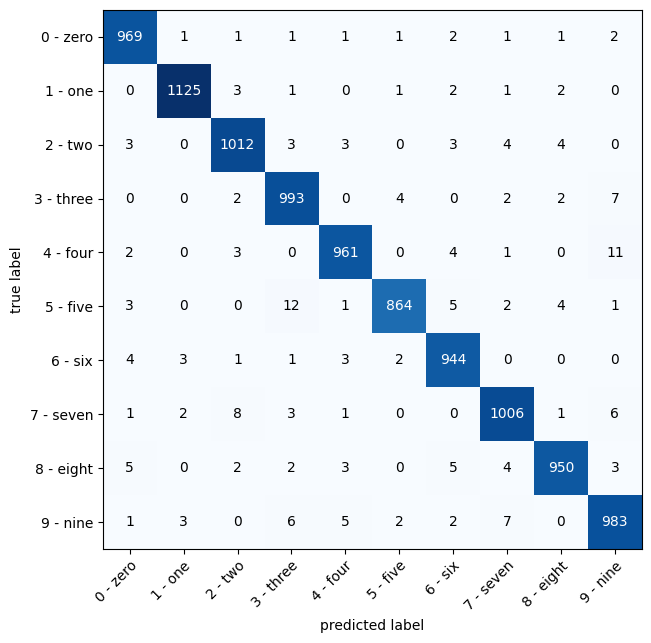

In [147]:
evaluation(model=model_mlp, test_dataloader=test_dataloader, device=device)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99       980
     1 - one       1.00      0.99      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.96      1.00      0.98      1010
    4 - four       1.00      0.97      0.98       982
    5 - five       0.98      0.97      0.97       892
     6 - six       0.99      0.98      0.99       958
   7 - seven       0.99      0.98      0.98      1028
   8 - eight       0.98      0.98      0.98       974
    9 - nine       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



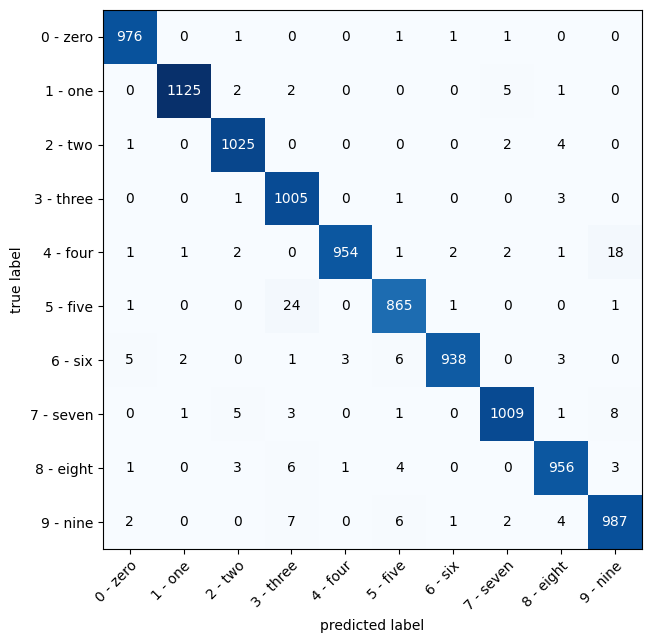

In [148]:
evaluation(model=model_cnn, test_dataloader=test_dataloader, device=device)

## 6. Inference

In [154]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) 
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [155]:
def plot_some_results(model: torch.nn.Module):
    # random.seed(42)
    test_samples = []
    test_labels = []
    for sample, label in random.sample(list(test_data), k=9):
        test_samples.append(sample)
        test_labels.append(label)

    pred_probs= make_predictions(model=model_mlp, 
                                 data=test_samples)
    pred_classes = pred_probs.argmax(dim=1)

    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    for i, sample in enumerate(test_samples):
        plt.subplot(nrows, ncols, i+1)

        plt.imshow(sample.squeeze(), cmap="gray")

        pred_label = class_names[pred_classes[i]]
        truth_label = class_names[test_labels[i]] 

        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g") # green text if correct
        else:
            plt.title(title_text, fontsize=10, c="r") # red text if wrong
        plt.axis(False);

**Inference using Trained MLPModel**

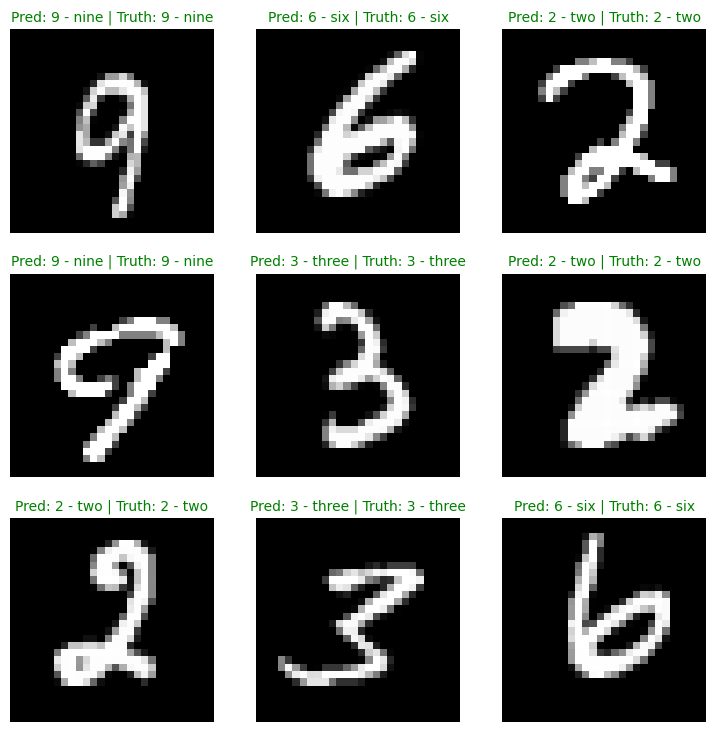

In [157]:
plot_some_results(model=model_mlp)

**Inference using Trained CNNModel**

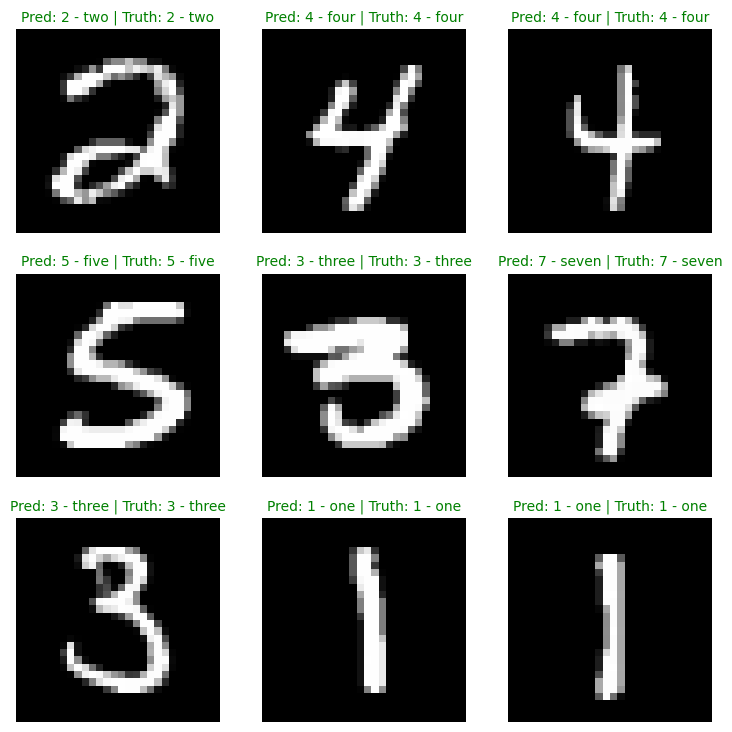

In [158]:
plot_some_results(model=model_cnn)